In [1]:
#from project_utilities import *
from emg_functions import *

...
Applying filter
...
Retrieving the muscle time activations from the punches
...
Number of punches: 10
-------------------------------
Muscle time activation for arm:
[0.16, 0.16, 0.14, 0.14, 0.17, 0.13, 0.14, 0.17, 0.14, 0.17]
Muscle time activation for chest:
[0.05, 0.03, 0.04, 0.04, 0.03, 0.03, 0.03, 0.04, 0.03, 0.04]
-------------------------------


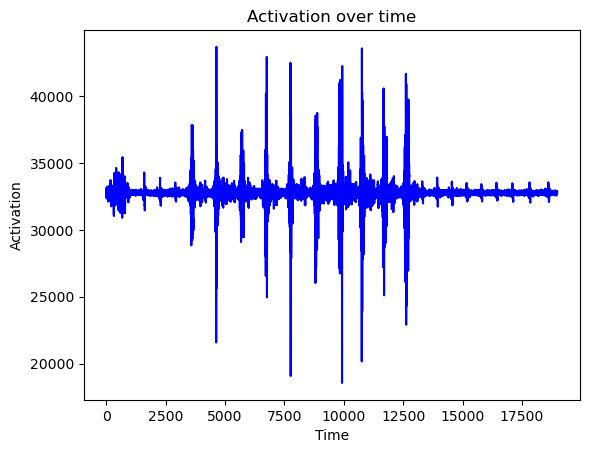

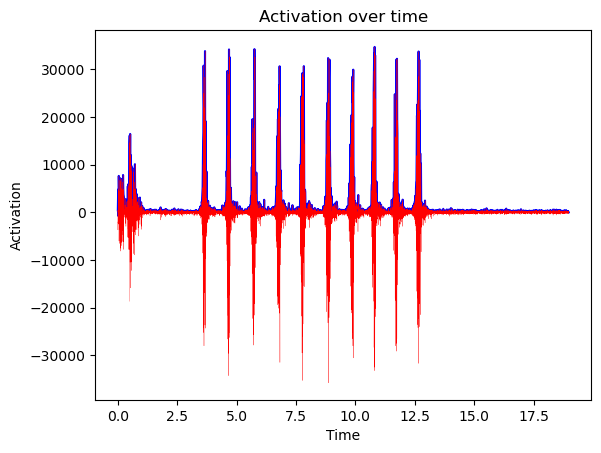

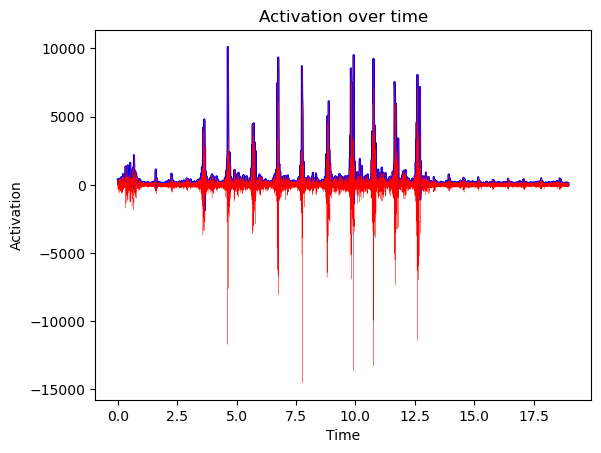

In [13]:
'''emgFilePath = './data/18oct/ioanna_hook.txt'#'./data/18oct/Lorenzo_hook.txt'#'./data/EMG_data/saffie_hook.txt'#'opensignals_0007804b3c23_2024-09-09_15-04-53.txt'
#--- manuell open (in pipeline)
#Open and reads the file with the EMG data to a long text string and saves it to rawData. Closes the file at the end.
with open(emgFilePath, 'r') as file:     
    rawData = file.read()      
    file.close
    pass        
#---'''
rawData = select_emg_file()
signalThreshold = 35000
sampleRate = get_sample_rate(rawData)


dataWithHeader = get_emg_data(rawData,sampleRate)
timeAdjustedEmg = find_first_punch(dataWithHeader,signalThreshold) #adjusted data is [time:EMG data Arm, EMG data chest]

emgDataArm = []
emgDataChest = []
timeValues = []
for row in timeAdjustedEmg:
    timeValues.append(row[0])
    emgDataArm.append(row[1])
    emgDataChest.append(row[2])
print("Collecting data from file")
print("...")
#filterdSignal = find_first_punch(dataTable, threshold)
lowcut = 20
highcut = 450
adjustedEmgArm = apply_filter(emgDataArm, lowcut, highcut, sampleRate) # adjustedEmg = filteredSignal
adjustedEmgChest = apply_filter(emgDataChest, lowcut, highcut, sampleRate)
print("Applying filter")
print("...")
window = 10
diffThreashold = 11 #for lorenzo jab: 6         Ioannas jab: 11
diffThreasholdChest = 2 #for lorenzo jab: 2     Ioannas jab: 2
envelopeValuesArm,timeValuesEnvelopeArm = envelope_emg(adjustedEmgArm,window,sampleRate)
envelopeValuesChest,timeValuesEnvelopeChest = envelope_emg(adjustedEmgChest,window,sampleRate)
zoomThreshold = 3000
zoomThresholdChest = 2000
print("Retrieving the muscle time activations from the punches")
print("...")

muscleActivationTimeArm = get_muscle_time(envelopeValuesArm,zoomThreshold,window,sampleRate,diffThreashold)
print(f"Number of punches: {len(muscleActivationTimeArm)}")
muscleActivationTimeChest = get_muscle_time(envelopeValuesChest,zoomThresholdChest,window,sampleRate,diffThreasholdChest)
print('-------------------------------')
print('Muscle time activation for arm:')
print(muscleActivationTimeArm)
print('Muscle time activation for chest:')
print(muscleActivationTimeChest)
print('-------------------------------')

plt.plot(emgDataChest, "b")
#plt.plot(timeValues,adjustedEmgArm, "r", lw = 0.2) 
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Activation over time')
plt.show()

plt.plot(timeValuesEnvelopeArm, envelopeValuesArm, "b")
plt.plot(timeValues,adjustedEmgArm, "r", lw = 0.2) 
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Activation over time')
plt.show()

plt.plot(timeValuesEnvelopeChest, envelopeValuesChest, "b")
plt.plot(timeValues,adjustedEmgChest, "r", lw = 0.2) 
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title('Activation over time')
plt.show()

In [4]:
#from imu_funcitons import *
import importlib
import imu_functions
from imu_functions import *
print(imu_functions.__file__)

/Users/beatrizfigueiredo/Documents/Project-course-CM2024/imu_functions.py


updated
Number of Punches: 10 -> [224.7516206061086, 227.6636826599281, 212.7307950435865, 227.70073349893096, 196.12414197984316, 221.79338103313884, 252.8075898235324, 256.1401243007745, 222.02992954209375, 213.29913096768945]


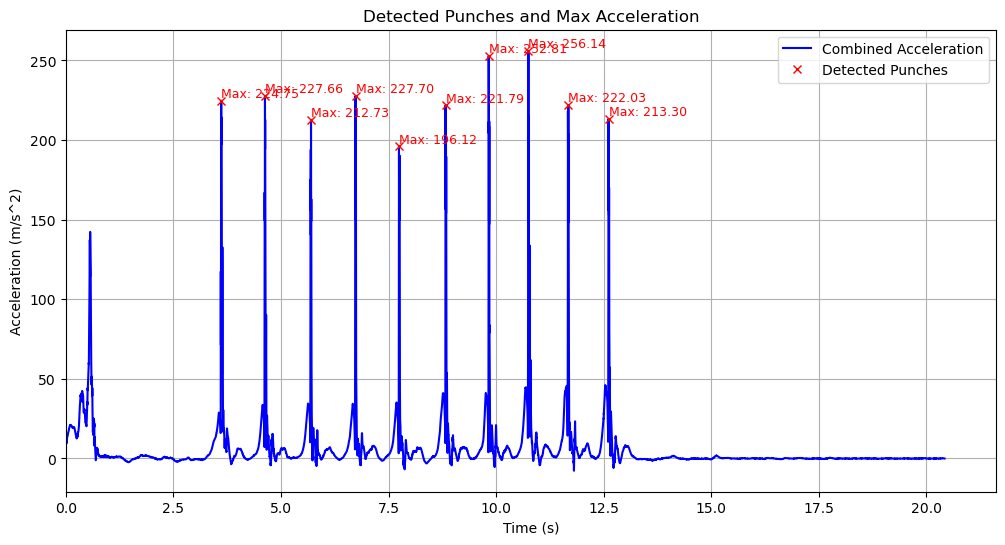

In [14]:
#Set threashold for zacc where timestamp starts, from calibration
threshold=10

# List to store the timestamps and data
timestampsAcc = []
xAcc = []
yAcc = []
zAcc = []
acc = []

# Read, extract, and process accelerometer data
jsonDataAcc = read_json_file()
timestampsAcc, xAcc, yAcc, zAcc = extract_acc_data(jsonDataAcc)

# Adjust timestamps to start from the first time Z-acceleration exceeds the threshold
adjustedTimestamps = adjust_timestamps_on_first_threshold(timestampsAcc, zAcc, threshold)


# Calculate the acceleration
acc = calculate_acceleration(xAcc, yAcc, zAcc)

# Detect punches and their max accelerations
window_size=20 #if all punches are not showing, it means we have to reduce the window_size
punch_peaks, max_accelerations, peak_timestamps = detect_punches_and_max_acc(adjustedTimestamps, acc, window_size)

# Print max acceleration values as an array for further use
print(f"Number of Punches: {len(max_accelerations)} -> {max_accelerations}")

# # Output the max accelerations and timestamps
# for i, max_acc in enumerate(max_accelerations):
#     print(f"Punch {i+1}: Max Acceleration = {max_acc:.2f} m/s^2 in the time window ({peak_timestamps[i]}s).")


# Plot the punches and max accelerations
plot_punches_with_max_acc(adjustedTimestamps, acc, punch_peaks, max_accelerations, peak_timestamps)

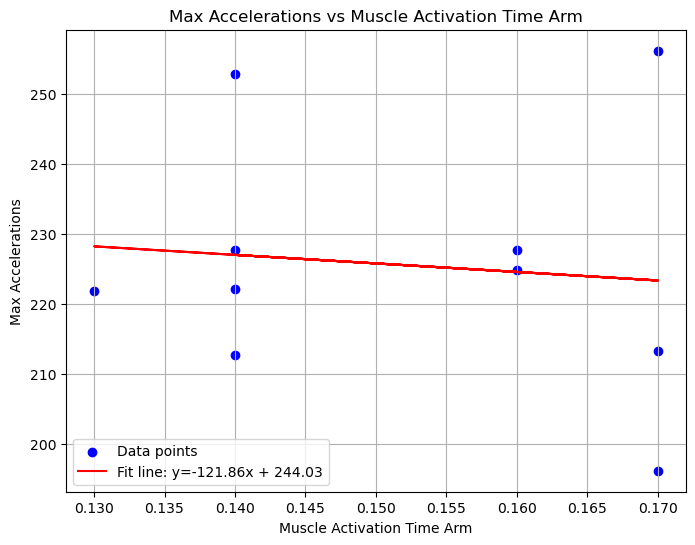

Linear regression equation: y = -121.86x + 244.03
Correlation coefficient (R^2): 0.01


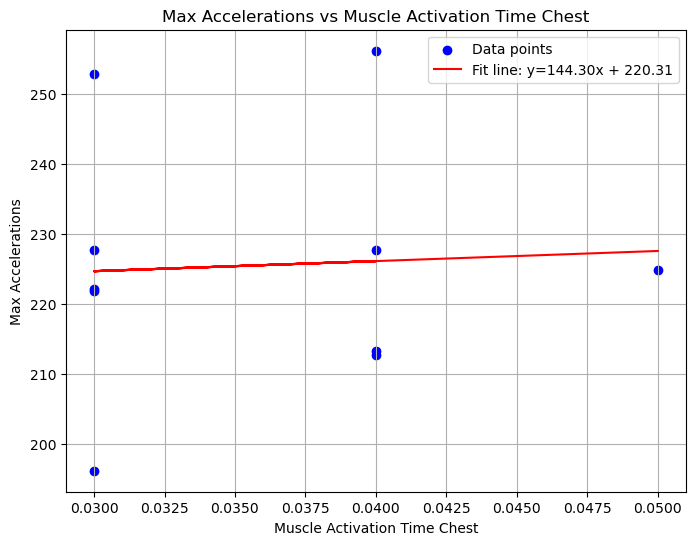

Linear regression equation: y = 144.30x + 220.31
Correlation coefficient (R^2): 0.00


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Check if lists have the same length
if len(max_accelerations) != len(muscleActivationTimeArm):
    print("Error: The lists 'max_accelerations' and 'muscleActivationTimeArm' must have the same length.")
else:
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(muscleActivationTimeArm, max_accelerations, color='blue', label='Data points')
    
    # Step 3: Linear regression to find the correlation/equation
    slope, intercept, r_value, p_value, std_err = stats.linregress(muscleActivationTimeArm, max_accelerations)
    
    # Create regression line values
    regression_line = [slope * x + intercept for x in muscleActivationTimeArm]
    
    # Plot the regression line
    plt.plot(muscleActivationTimeArm, regression_line, color='red', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
    
    # Step 4: Customize the plot
    plt.title('Max Accelerations vs Muscle Activation Time Arm')
    plt.xlabel('Muscle Activation Time Arm')
    plt.ylabel('Max Accelerations')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()
    
    # Print correlation info
    print(f'Linear regression equation: y = {slope:.2f}x + {intercept:.2f}')
    print(f'Correlation coefficient (R^2): {r_value**2:.2f}')

    # Check if lists have the same length
if len(max_accelerations) != len(muscleActivationTimeChest):
    print("Error: The lists 'max_accelerations' and 'muscleActivationTimeChest' must have the same length.")
else:
    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(muscleActivationTimeChest, max_accelerations, color='blue', label='Data points')
    
    # Step 3: Linear regression to find the correlation/equation
    slope, intercept, r_value, p_value, std_err = stats.linregress(muscleActivationTimeChest, max_accelerations)
    
    # Create regression line values
    regression_line = [slope * x + intercept for x in muscleActivationTimeChest]
    
    # Plot the regression line
    plt.plot(muscleActivationTimeChest, regression_line, color='red', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
    
    # Step 4: Customize the plot
    plt.title('Max Accelerations vs Muscle Activation Time Chest')
    plt.xlabel('Muscle Activation Time Chest')
    plt.ylabel('Max Accelerations')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()
    
    # Print correlation info
    print(f'Linear regression equation: y = {slope:.2f}x + {intercept:.2f}')
    print(f'Correlation coefficient (R^2): {r_value**2:.2f}')